# Twitter Sentiment & Emotion Analysis
### Google Colab ready - compatible with Python 3.12.11 (latest version)


## Step 1 - Install Dependencies
Run this cell to install required packages

In [1]:
!pip install -q transformers torch pandas matplotlib seaborn wordcloud pillow tqdm

## Step 2 - Imports and setup

In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from transformers import pipeline
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12,6)
tqdm.pandas()
print('Imports ready')

Imports ready


## Step 3 - Load Models
Sentiment: `cardiffnlp/twitter-roberta-base-sentiment`

Emotion: `bhadresh-savani/bert-base-go-emotion`

In [3]:
print('Loading sentiment model...')
sentiment_model = 'cardiffnlp/twitter-roberta-base-sentiment'
sentiment_analyzer = pipeline('sentiment-analysis', model=sentiment_model, tokenizer=sentiment_model)
print('Loading emotion model...')
emotion_model = 'bhadresh-savani/bert-base-go-emotion'
emotion_analyzer = pipeline('text-classification', model=emotion_model, tokenizer=emotion_model, top_k=1)
print('Models loaded')

Loading sentiment model...


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Device set to use cuda:0


Loading emotion model...


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cuda:0


Models loaded


## Step 4 - Data input (choose one)
- Option A: Upload CSV with a `text` column (recommended)
- Option B: Paste manual tweets (small demo)

In [4]:
# Option A: Upload CSV
from google.colab import files
print('If you have a CSV, upload it now (must contain a text column)')
uploaded = files.upload()
if uploaded:
    fname = list(uploaded.keys())[0]
    df = pd.read_csv(fname, encoding='utf-8', low_memory=False)
    # find text column
    if 'text' in df.columns:
        text_col = 'text'
    elif 'content' in df.columns:
        text_col = 'content'
    elif 'tweet' in df.columns:
        text_col = 'tweet'
    else:
        text_col = df.columns[0]
        print(f"No 'text' column found — using {text_col} as text column")
    df = df.rename(columns={text_col: 'text'})
    df = df[['text']].dropna().reset_index(drop=True)
    print(f'Loaded {len(df)} rows from {fname}')
else:
    # Option B: small manual demo dataset
    demo = [
        'I love the new update! Best purchase ever 🎉',
        'So frustrated with the service, waited 2 hours',
        'This is okay, nothing special',
        'Amazing experience, would recommend',
        'Terrible product. Do not buy!',
        'I am excited for the event tomorrow',
        'Feeling sad about the recent news',
        'That was hilarious 😂',
        'Neutral statement about nothing',
        'I hate the new policy. Unacceptable.'
    ]
    df = pd.DataFrame({'text': demo})
    print('Using demo dataset with', len(df), 'tweets')
df.head()

If you have a CSV, upload it now (must contain a text column)


Saving sampled_30k.csv to sampled_30k.csv
Loaded 30000 rows from sampled_30k.csv


,text
0,...? this weather! It's about time the sun sta...
1,@LTLline How you go to my job when im not ther...
2,Feel myself getting sick....ughh not cool. Jak...
3,"going crazy, installing cslatex"
4,"Shit, no more maths HL this semester! WTF, we..."


## Step 5 - Preprocess Text

In [5]:
def clean_text(x):
    if not isinstance(x, str):
        return ''
    x = re.sub(r'http\S+|www\S+|https\S+', '', x)
    x = re.sub(r'@\w+', '@user', x)
    x = re.sub(r'#', '', x)
    x = re.sub(r'\s+', ' ', x).strip()
    return x

df['clean_text'] = df['text'].progress_apply(clean_text)
df = df[df['clean_text'].str.len() > 0].reset_index(drop=True)
print('Preprocessing done. Rows:', len(df))
df.head()

  0%|          | 0/30000 [00:00<?, ?it/s]

Preprocessing done. Rows: 29999


,text,clean_text
0,...? this weather! It's about time the sun sta...,...? this weather! It's about time the sun sta...
1,@LTLline How you go to my job when im not ther...,@user How you go to my job when im not there N...
2,Feel myself getting sick....ughh not cool. Jak...,Feel myself getting sick....ughh not cool. Jak...
3,"going crazy, installing cslatex","going crazy, installing cslatex"
4,"Shit, no more maths HL this semester! WTF, we...","Shit, no more maths HL this semester! WTF, we ..."


## Step 6 - Sentiment Analysis

In [6]:
def analyze_sent(text):
    try:
        r = sentiment_analyzer(text[:512])[0]
        label = r['label']
        score = r.get('score', None)
        # map if needed
        if label.lower() in ['label_0','negative']:
            lab = 'Negative'
        elif label.lower() in ['label_2','positive']:
            lab = 'Positive'
        else:
            lab = 'Neutral'
        return lab, score
    except Exception as e:
        return 'Neutral', 0.5

results = df['clean_text'].progress_apply(lambda t: analyze_sent(t))
df['sentiment'] = results.apply(lambda x: x[0])
df['sentiment_score'] = results.apply(lambda x: x[1])
print('Sentiment done')
df[['clean_text','sentiment']].head()

  0%|          | 0/29999 [00:00<?, ?it/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Sentiment done


,clean_text,sentiment
0,...? this weather! It's about time the sun sta...,Positive
1,@user How you go to my job when im not there N...,Negative
2,Feel myself getting sick....ughh not cool. Jak...,Negative
3,"going crazy, installing cslatex",Neutral
4,"Shit, no more maths HL this semester! WTF, we ...",Negative


## Step 7 - Emotion Classification

In [7]:
def analyze_em(text):
    try:
        res = emotion_analyzer(text[:512])[0][0]
        return res['label'], res.get('score', None)
    except Exception:
        return 'neutral', 0.5

emres = df['clean_text'].progress_apply(lambda t: analyze_em(t))
df['emotion'] = emres.apply(lambda x: x[0])
df['emotion_score'] = emres.apply(lambda x: x[1])
print('Emotion done')
df[['clean_text','emotion']].head()

  0%|          | 0/29999 [00:00<?, ?it/s]

Emotion done


,clean_text,emotion
0,...? this weather! It's about time the sun sta...,curiosity
1,@user How you go to my job when im not there N...,neutral
2,Feel myself getting sick....ughh not cool. Jak...,disappointment
3,"going crazy, installing cslatex",neutral
4,"Shit, no more maths HL this semester! WTF, we ...",annoyance


## Step 8 - Visualizations

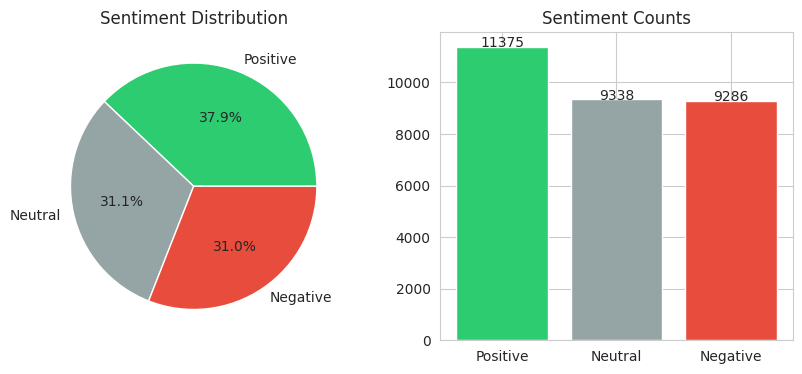

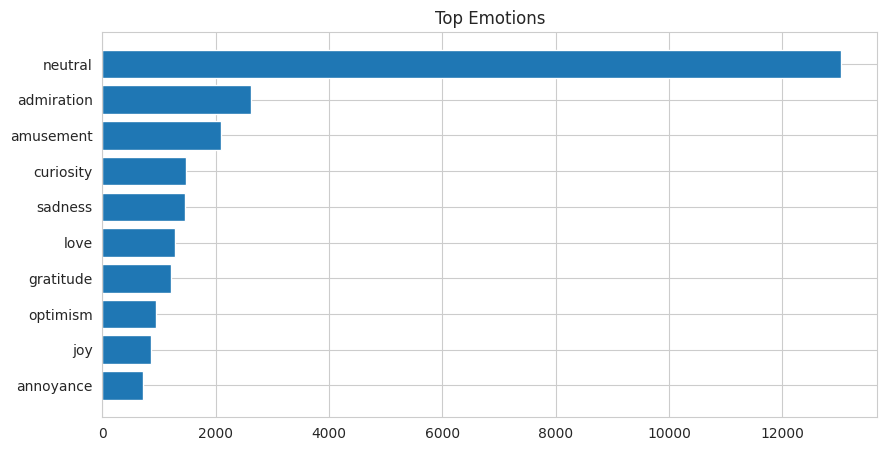

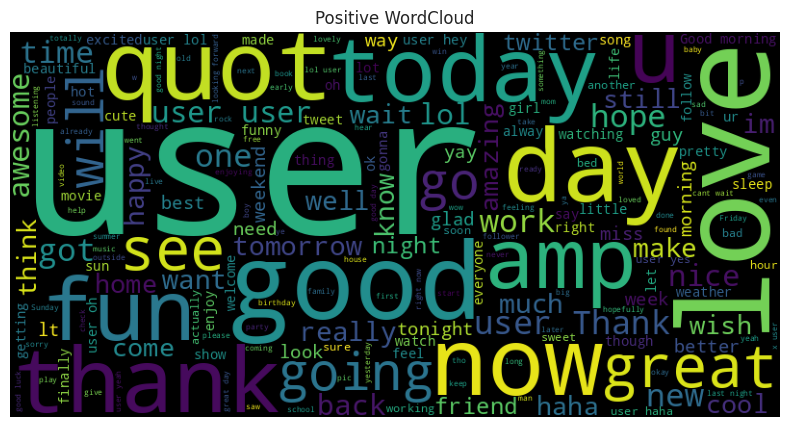

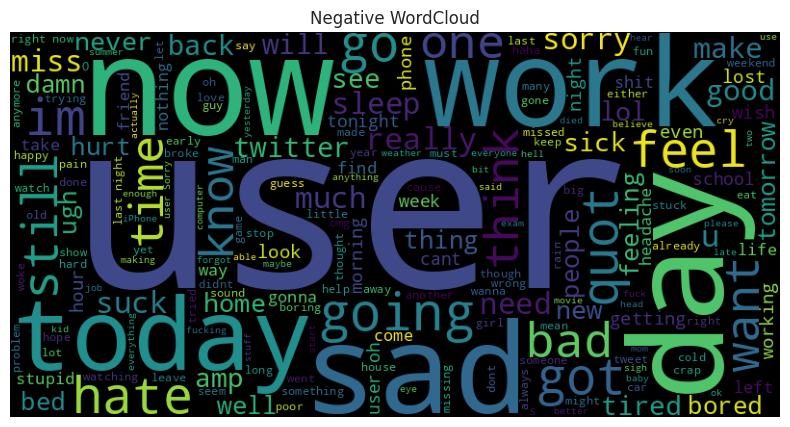

In [8]:
import matplotlib.pyplot as plt
sent_counts = df['sentiment'].value_counts()
colors = [ '#2ecc71', '#95a5a6', '#e74c3c']
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.pie(sent_counts.values, labels=sent_counts.index, autopct='%1.1f%%', colors=colors)
plt.title('Sentiment Distribution')
plt.subplot(1,2,2)
bars = plt.bar(sent_counts.index, sent_counts.values, color=colors)
for bar in bars:
    y = bar.get_height()
    plt.text(bar.get_x()+bar.get_width()/2, y+0.5, int(y), ha='center')
plt.title('Sentiment Counts')
plt.show()

top_em = df['emotion'].value_counts().head(10)
plt.figure(figsize=(10,5))
plt.barh(top_em.index, top_em.values)
plt.title('Top Emotions')
plt.gca().invert_yaxis()
plt.show()

pos_text = ' '.join(df[df['sentiment']=='Positive']['clean_text'].tolist())
neg_text = ' '.join(df[df['sentiment']=='Negative']['clean_text'].tolist())
if len(pos_text)>0:
    wc = WordCloud(width=800, height=400).generate(pos_text)
    plt.figure(figsize=(12,5)); plt.imshow(wc); plt.axis('off'); plt.title('Positive WordCloud'); plt.show()
if len(neg_text)>0:
    wc = WordCloud(width=800, height=400).generate(neg_text)
    plt.figure(figsize=(12,5)); plt.imshow(wc); plt.axis('off'); plt.title('Negative WordCloud'); plt.show()

## Step 9 - Export Results

In [9]:
out = df[['text','clean_text','sentiment','sentiment_score','emotion','emotion_score']]
out_fname = 'sentiment_emotion_results.csv'
out.to_csv(out_fname, index=False)
from google.colab import files
files.download(out_fname)
print('Saved and downloaded', out_fname)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saved and downloaded sentiment_emotion_results.csv


## Step 10 - Summary Statistics
Quick summary of counts and average confidences

In [10]:
print('Total tweets:', len(df))
print('\nSentiment distribution:')
print(df['sentiment'].value_counts())
print('\nTop emotions:')
print(df['emotion'].value_counts().head(10))
print('\nAverage confidences:')
print('Sentiment:', df['sentiment_score'].mean())
print('Emotion:', df['emotion_score'].mean())

Total tweets: 29999

Sentiment distribution:
sentiment
Positive    11375
Neutral      9338
Negative     9286
Name: count, dtype: int64

Top emotions:
emotion
neutral       13028
admiration     2615
amusement      2099
curiosity      1468
sadness        1452
love           1278
gratitude      1206
optimism        946
joy             857
annoyance       708
Name: count, dtype: int64

Average confidences:
Sentiment: 0.7643998839516708
Emotion: 0.5302241776864876


In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Note:**

This MVP uses uploaded CSVs or a small demo list and runs models via Hugging Face pipelines. It avoids scraping to stay compatible with Colab Python 3.12.11